In [390]:
import torch as torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [1]:
words = open("../data/names.txt", "r").read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


Text(0.5, 1.0, 'Neural architecture from Bengio et al. 2003 MLP language model paper')

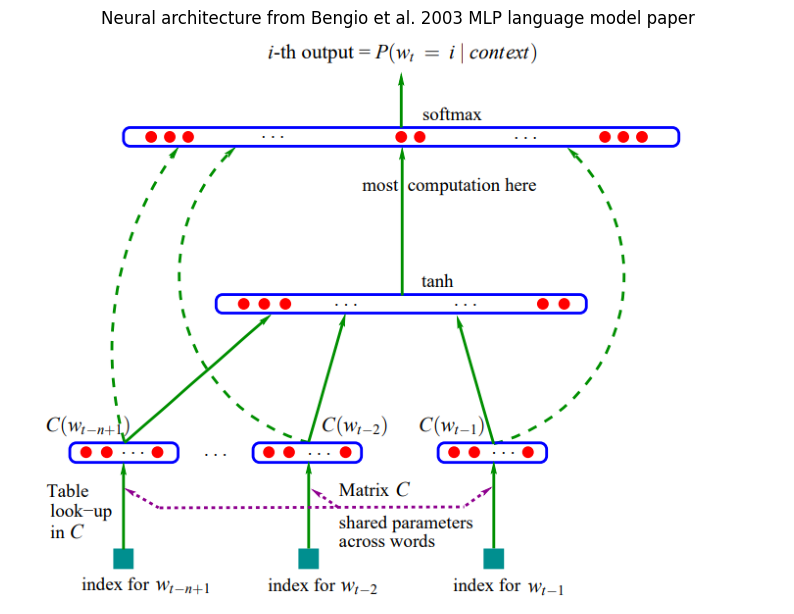

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(plt.imread("../images/MLP.png"));
plt.axis("off");
plt.title("Neural architecture from Bengio et al. 2003 MLP language model paper")

# 1- Preparing The Dataset

## 1.1- Build the vocabulary

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## 1.2- Build the dataset

In [1]:
block_size = 3

X, Y = [], []

for w in words:

    print(w)

    # init context with [0, 0, 0]
    context = [0] * block_size

    for ch in w + ".":
        # idx of label letter
        ix = stoi[ch]

        # append context and label
        X.append(context)
        Y.append(ix)
        
        # print them in form (ABC --> D)
        print(f"{''.join(itos[i] for i in context)} --> {itos[ix]}")

        # advance context
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [172]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

## 1.3- Prepare The Embeddings

In [135]:
C = torch.rand((27, 2))

# Embedding an int

# 1- explicitly (faster ✅)
print(C[5])
# 2- using one hot
print(F.one_hot(torch.tensor([5]), num_classes=27).float() @ C)

tensor([0.8418, 0.6258])
tensor([[0.8418, 0.6258]])


In [136]:
# Embedding a full tensor
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

# 2- Building The Model

## 2.1- Hidden Layers

In [406]:
in_size = 2 * 3 # 3 embeddings, 2D each
hidden_size = 100 # no. of neurons

W1 = torch.randn((in_size, hidden_size))
b1 = torch.randn(hidden_size)

h = emb.view(-1, in_size) @ W1 + b1

In [407]:
out_size = 27 # no. of neurons

W2 = torch.randn((hidden_size, out_size))
b2 = torch.randn(out_size)

logtis = h @ W2 + b2

logtis.shape

torch.Size([182437, 27])

## 2.2- Applying Softmax

In [139]:
counts = logtis.exp()
prob = counts / counts.sum(1, keepdims = True)

print(f"prob shape is {prob.shape}")
# check each row sums to 1
prob.sum(dim = 1)

prob shape is torch.Size([32, 27])


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

## 2.3- Negative Log Likelihood Loss

In [150]:
# current probabilities of the correct labels y_true (with current weights)
print(prob[torch.arange(182625), Y])

# nll loss
loss = - prob[torch.arange(182625), Y].log().mean()
loss

tensor([6.7329e-18, 1.3112e-32, 1.5793e-32, 1.0008e-14, 2.2751e-02, 2.6449e-27,
        3.7243e-23, 2.5679e-01, 7.8711e-18, 2.0374e-07, 8.2137e-20, 2.3330e-06,
        1.7979e-20, 4.6814e-24, 2.0101e-15, 2.8672e-04, 1.0886e-02, 8.9410e-01,
        6.9865e-13, 2.7844e-09, 7.6535e-14, 1.4418e-10, 2.3258e-19, 7.4299e-15,
        1.6532e-03, 9.8420e-01, 5.6394e-28, 6.0339e-28, 5.3534e-18, 3.1203e-07,
        6.1320e-22, 7.1449e-05])


tensor(31.7150)

## 2.4- Model Summary

In [391]:
g = torch.Generator().manual_seed(2147483647)
C = torch.rand((27, 2), generator = g)
W1 = torch.randn((in_size, hidden_size), generator = g)
b1 = torch.randn(hidden_size, generator = g)
W2 = torch.randn((hidden_size, out_size), generator = g)
b2 = torch.randn(out_size, generator = g)

parameters = [C, W1, b1, W2, b2]
print(f"number of params = {sum(p.nelement() for p in parameters)}")

number of params = 3481


In [159]:
emb = C[X]

h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2

# calculate the loss
# 1- Manually
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims = True)
# loss = - prob[torch.arange(32), Y].log().mean()

# 2- Using Cross Entropy
loss = F.cross_entropy(logits, Y)

loss

tensor(10.1065)

In [165]:
# Cross Entropy is better: beside being more efficient, it prevents overflow by subtracting the max +ve value
logits = torch.tensor([-100, -3, 0, 100]) - 100
counts = logits.exp()
probs = counts / counts.sum()

print(counts)

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])


# 3- Training

In [402]:
g = torch.Generator().manual_seed(12344321)
C = torch.rand((27, 2), generator = g)
W1 = torch.randn((in_size, hidden_size), generator = g)
b1 = torch.randn(hidden_size, generator = g)
W2 = torch.randn((hidden_size, out_size), generator = g)
b2 = torch.randn(out_size, generator = g)

parameters = [C, W1, b1, W2, b2]
print(f"number of params = {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

number of params = 3481


## 3 3.1- Over 32 examples only

In [215]:
for _ in range(100):

    # Forward Pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.1 * p.grad

print(loss.item())

0.5580253601074219


we are getting very low loss because we're overfitting on 32 examples

## 3.2- Over the dataset (modify X & Y from Build dataset cell)

In [258]:
for _ in range(100):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) # now size of emb is (32, 3, 2) again

    # Forward Pass
    emb = C[X[ix]]
    # print(emb.shape)
    h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.1 * p.grad

print(f"mini batch loss {loss.item()}")

mini batch loss 2.5312814712524414


In [259]:
# Forward Pass
emb = C[X]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)

print(f"Training set loss {loss.item()}")

Training set loss 2.562408208847046


## 3.3- Finding a good initial learning rate

Text(0.5, 1.0, 'stepping between exponents')

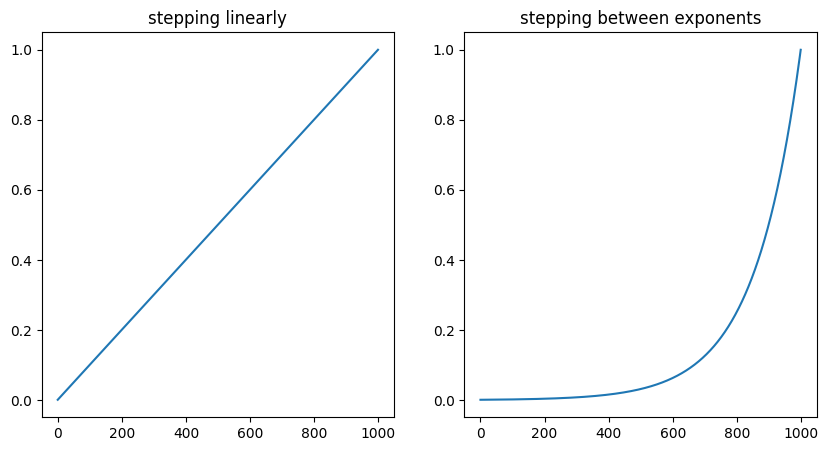

In [312]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

# plot both next to each other
fig, axes = plt.subplots(1,2, figsize = (10,5))

axes[0].plot(torch.linspace(0.001, 1, 1000))
axes[0].set_title("stepping linearly")

axes[1].plot(lrs)
axes[1].set_title("stepping between exponents")


In [2]:
lossi = []

for i in range(1000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) # now size of emb is (32, 3, 2) again

    # Forward Pass
    emb = C[X[ix]]
    # print(emb.shape)
    h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data -= lr * p.grad

    # track loss
    lossi.append(loss.item())

print(f"mini batch loss {loss.item()}")

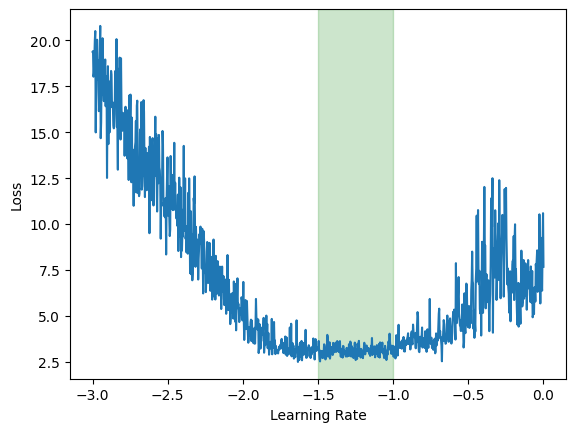

In [337]:
plt.plot(lre, lossi)

plt.axvspan(-1.5, -1, color='g', alpha=0.2)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()

In [355]:
# use the new learning rate
lossi = []

for i in range(10000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) # now size of emb is (32, 3, 2) again

    # Forward Pass
    emb = C[X[ix]]
    # print(emb.shape)
    h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    # set lr to 0.1, then to 0.01 
    lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track loss
    lossi.append(loss.item())

print(f"mini batch loss {loss.item()}")
# Forward Pass
emb = C[X]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)

print(f"Training set loss {loss.item()}")

mini batch loss 2.274751901626587
Training set loss 2.3924827575683594


we superpassed bigram loss (about 2.45)

# 4- Train Dev Test Split

## 4.1 Prepare the datasets

In [401]:
def build_dataset(words, block_size = 3):  

  X, Y = [], []
  
  for w in words:

    context = [0] * block_size
    for ch in w + '.':

      ix = stoi[ch]

      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


## 4.2 Training

In [396]:
g = torch.Generator().manual_seed(12344321)
C = torch.rand((27, 2), generator = g)
W1 = torch.randn((in_size, hidden_size), generator = g)
b1 = torch.randn(hidden_size, generator = g)
W2 = torch.randn((hidden_size, out_size), generator = g)
b2 = torch.randn(out_size, generator = g)

# use Xtr and Ytr
X = Xtr
Y = Ytr

parameters = [C, W1, b1, W2, b2]
print(f"number of params = {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

number of params = 3481


In [399]:
# use the new learning rate
lossi = []

for i in range(10000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # now size of emb is (32, 3, 2) again

    # Forward Pass
    emb = C[Xtr[ix]]
    # print(emb.shape)
    h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    # set lr to 0.1, then to 0.01 
    lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track loss
    lossi.append(loss.item())

print(f"mini batch loss {loss.item()}")

# Forward Pass
emb = C[Xdev]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)

print(f"Dev set loss {loss.item()}")

mini batch loss 2.0412771701812744
Dev set loss 2.3511404991149902


In [400]:
# Forward Pass
emb = C[Xtr]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)

print(f"Training set loss {loss.item()}")

Training set loss 2.335360050201416


Comment: Training loss is close to Dev loss ➡️ The model isn't overfitting

# 5- Expirement1: Larger Hidden Layer

In [410]:
hidden_size = 300

g = torch.Generator().manual_seed(12344321)
C = torch.rand((27, 2), generator = g)
W1 = torch.randn((in_size, hidden_size), generator = g)
b1 = torch.randn(hidden_size, generator = g)
W2 = torch.randn((hidden_size, out_size), generator = g)
b2 = torch.randn(out_size, generator = g)

# use Xtr and Ytr
X = Xtr
Y = Ytr

parameters = [C, W1, b1, W2, b2]
print(f"number of params = {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

number of params = 10281


In [417]:
# use the new learning rate
lossi = []
stepi = []

for i in range(30000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # now size of emb is (32, 3, 2) again

    # Forward Pass
    emb = C[Xtr[ix]]
    # print(emb.shape)
    h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    # set lr to 0.1, then to 0.01 
    lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track loss
    lossi.append(loss.item())
    stepi.append(i)

print(f"mini batch loss {loss.item()}")

# Forward Pass
emb = C[Xdev]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)

print(f"Dev set loss {loss.item()}")

mini batch loss 2.651702404022217
Dev set loss 2.2780323028564453


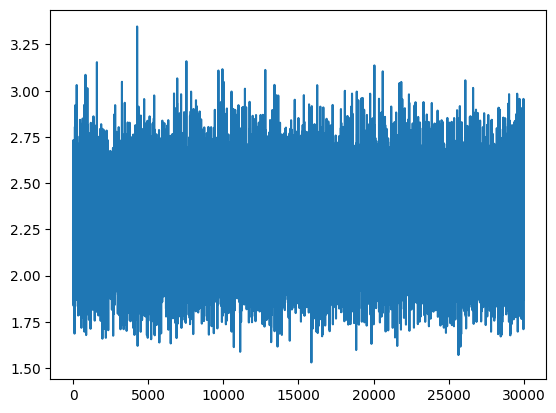

In [418]:
plt.plot(stepi, lossi)

# 6- Visualizing The Embedding Vectors

In [422]:
C[:,0].data

tensor([ 0.3924,  0.1790, -0.2173, -0.0391, -0.2110,  0.1030, -0.2346, -0.0388,
        -0.1586, -0.2852, -0.4666, -0.1823, -0.8607, -0.4316, -0.2933, -0.0182,
        -0.0755, -1.1123, -0.5318, -0.0229, -0.0625, -0.0508, -0.5064, -0.2306,
        -0.1021, -0.5761, -0.2751])

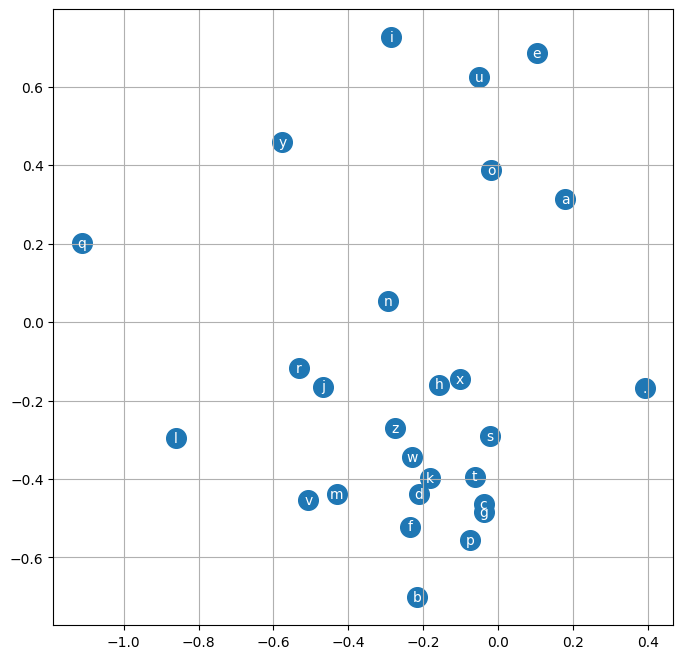

In [430]:
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = "center", va = "center", color = "white")
plt.grid("minor")

# 7- Expirement2: Larger Embedding Size

In [434]:
in_size = 3 * 10
hidden_size = 200

g = torch.Generator().manual_seed(12344321)
C = torch.rand((27, 10), generator = g)
W1 = torch.randn((in_size, hidden_size), generator = g)
b1 = torch.randn(hidden_size, generator = g)
W2 = torch.randn((hidden_size, out_size), generator = g)
b2 = torch.randn(out_size, generator = g)

# use Xtr and Ytr
X = Xtr
Y = Ytr

parameters = [C, W1, b1, W2, b2]
print(f"number of params = {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

number of params = 11897


In [445]:
# use the new learning rate
lossi = []
stepi = []

In [455]:
for i in range(20000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # now size of emb is (32, 3, 2) again

    # Forward Pass
    emb = C[Xtr[ix]]
    # print(emb.shape)
    h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    # set lr to 0.1, then to 0.01 
    lr = 0.001
    for p in parameters:
        p.data -= lr * p.grad

    # track loss
    lossi.append(loss.log10().item())
    stepi.append(i)

print(f"mini batch loss {loss.item()}")

mini batch loss 2.514514684677124


In [456]:
# Forward Pass
emb = C[Xtr]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)

print(f"Training set loss {loss.item()}")

# Forward Pass
emb = C[Xdev]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)

print(f"Dev set loss {loss.item()}")


Training set loss 2.211817502975464
Dev set loss 2.224280595779419


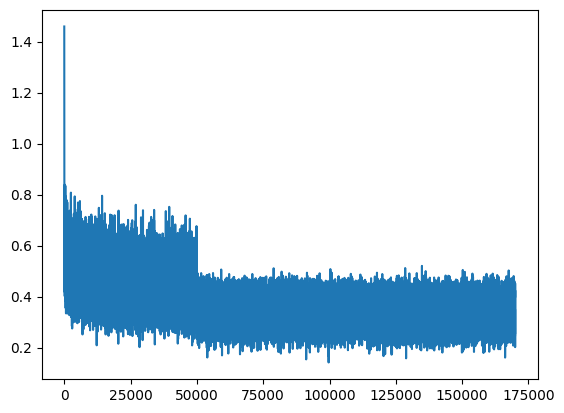

In [457]:
plt.plot(lossi)

# 8- Sampling From the model

In [461]:
emb.view(1,-1).shape

torch.Size([1, 30])

In [472]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # Forward pass
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)

        ix = torch.multinomial(probs, num_samples = 1).item()

        # Shift the Context Window
        context = context[1:] + [ix]

        if ix == 0:
            break

        out.append(ix)
    
    print("".join(itos[i] for i in out))
        

machelena
bea
emaelayzim
shalli
talah
charvon
trigh
hellerith
tevid
key
vey
brin
mahlan
bedida
sazisanvayah
ostesin
lah
jefhella
gen
jal
